In [68]:
import asyncio
from tardis_client import TardisClient, Channel
import pandas as pd
import numpy as np
import grpc
import sys
import inference_pb2_grpc as pb2_grpc
import inference_pb2 as pb2
import matplotlib.pyplot as plt

In [51]:
class TestClient(object):
    """
    Client for testing inference gRPC
    """

    def __init__(self):
        self.host = '3.139.238.241'
        #self.host = 'localhost'
        self.server_port = 5125

        # instantiate a channel
        self.channel = grpc.insecure_channel(
            '{}:{}'.format(self.host, self.server_port))

        # bind the client and the server
        self.stub = pb2_grpc.InferenceStub(self.channel)

    def send(self, tx, modelHash, modelInput):
        """
        Client function to call the rpc for inference
        """
        message = pb2.InferenceParameters(tx=tx, modelHash=modelHash, modelInput = modelInput)
        return self.stub.RunInference(message)

def inference(vol5b, vol10b, vol20b):
    client = TestClient()
    result = client.send(tx = "0x123", modelHash="QmXQpupTphRTeXJMEz3BCt9YUF6kikcqExxPdcVoL1BBhy", modelInput=str([[vol5b, vol10b, vol20b]]))
    return float(result.value)

In [52]:
async def kraken(symbol, start_date, end_date):
    data = []
    tardis_client = TardisClient(api_key='TD.EGbmz1ZjK48X8Umz.xA3stUptkohr9Bs.kkKNJo2yL78bZVP.YJRJl3xrqDmyvJE.ymLsIiFZJ-tTtLx.s2Xh')

    messages = tardis_client.replay(
        exchange="kraken",
        from_date=start_date,
        to_date=end_date,
        filters=[Channel(name="spread", symbols=[symbol])],
    )
    
    async for local_timestamp, message in messages:
        timestamp = float(message[1][2])
        bid = float(message[1][0])
        ask = float(message[1][1])
        mid = (bid + ask) / 2
        spread = abs(ask-bid) / mid
        data.append([timestamp, mid, spread])
    return data

data = sorted(await kraken("ETH/USDT", "2022-11-10", "2022-11-11"), key=lambda x: x[0])

In [53]:
raw_df = pd.DataFrame(data, columns =['timestamp', 'price', 'spread'], dtype = float).sort_values(by=['timestamp'])    

In [54]:
i = 1
price_sum = data[0][1]
spread_sum = data[0][2]
count = 1
timestamp = data[0][0]
processed_data = []
while i < len(data):
    if (data[i][0] - timestamp > 12):
        processed_data.append([timestamp, price_sum/count, spread_sum/count])
        timestamp = data[i][0]
        price_sum = data[i][1]
        spread_sum = data[i][2]
        count = 1
    else:
        count += 1
        price_sum += data[i][1]
        spread_sum += data[i][2]
    i += 1

In [133]:
df = pd.DataFrame(processed_data, columns =['timestamp', 'price', 'spread'], dtype = float).sort_values(by=['timestamp'])    

In [134]:
windows = [5, 10, 20]
for w in windows:
    df['vol_' + str(w) + 'b'] = df['price'].rolling(w).std() / df['price']
    df['spread_' + str(w) + 'b'] = df['spread'].rolling(w).mean()
df = df.dropna()

In [135]:
df.head()

,timestamp,price,spread,vol_5b,spread_5b,vol_10b,spread_10b,vol_20b,spread_20b
19,1.668039e+09,1091.616462,0.002661,0.002340,0.001889,0.003476,0.001557,0.003613,0.001414
20,1.668039e+09,1090.978655,0.002566,0.002264,0.002074,0.003077,0.001701,0.003552,0.001484
21,1.668039e+09,1089.967889,0.002060,0.002184,0.002116,0.002288,0.001775,0.003623,0.001537
22,1.668039e+09,1092.242762,0.001611,0.002149,0.002126,0.001935,0.001817,0.003602,0.001551
23,1.668039e+09,1092.376680,0.002861,0.000908,0.002352,0.001949,0.002001,0.003590,0.001622


In [109]:
class eth_usdc:
    def __init__(self, eth, usdc):
        self.profit = 0
        self.eth = eth
        self.usdc = usdc
        self.product = eth * usdc
    
    def trade(self, direction, eth, price, fee):
        self.profit += fee * (eth * price)
        eth = eth * (1-fee)
        if direction == 'buy':
            return self.buy(eth, price)
        else:
            return self.sell(eth, price)
    
    # Returns amount of ETH in USD terms
    def buy(self, eth, price):
        self.eth -= eth
        diff = (self.product / self.eth) - self.usdc 
        self.usdc = self.product / self.eth
        return diff * price
    
    # Returns amount of USDC received
    def sell(self, eth, price):
        self.eth += eth
        diff = (self.eth - (self.product / self.usdc)) * price
        self.usdc = self.product / self.eth
        return diff

    def balance(self, price):
        return self.profit + self.usdc + (price * self.eth)
    
    def profitable(self, eth, usdc, price, fee):
        return ((price*eth) - usdc) / (2*price)

In [114]:
history = {"fee": [], "eth": [], "usdc": [], "price": [], "balance": []}
trader_profit = 0
pool = eth_usdc(1000000, 1000000 * df.iloc[0,1])
for date, row in df.T.iteritems():
    fee = inference(row['vol_5b'], row['vol_10b'], row['vol_20b'])
    history['fee'].append(fee)
    history['eth'].append(pool.eth)
    history['usdc'].append(pool.usdc)
    history['price'].append(row['price'])
    history['balance'].append(pool.balance(row['price']))
    amt = pool.profitable(eth, usdc, row['price'], fee) != 0
    if (amt > 0):
        trader_profit += pool.trade('buy', abs(amt), row['price'], fee)
    elif (amt < 0):
        trader_profit += pool.trade('sell', abs(amt), row['price'], fee)

<ipython-input-114-51e07a9fa026>:4: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for date, row in df.T.iteritems():


In [146]:
history2 = {"fee": [], "eth": [], "usdc": [], "price": [], "balance": []}
trader_profit = 0
pool = eth_usdc(1000000, 1000000 * df.iloc[0,1])
for date, row in df.T.iteritems():
    fee = 0.001
    history2['fee'].append(fee)
    history2['eth'].append(pool.eth)
    history2['usdc'].append(pool.usdc)
    history2['price'].append(row['price'])
    history2['balance'].append(pool.balance(row['price']))
    amt = pool.profitable(eth, usdc, row['price'], fee) != 0
    if (amt > 0):
        trader_profit += pool.trade('buy', abs(amt), row['price'], fee)
    elif (amt < 0):
        trader_profit += pool.trade('sell', abs(amt), row['price'], fee)

<ipython-input-146-2943bb758c02>:4: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for date, row in df.T.iteritems():


In [147]:
results = pd.DataFrame(list(zip(history['balance'], history2['balance'])),columns =['Dynamic', 'Static'])

In [148]:
results['Delta'] = results['Dynamic'] - results['Static']

<AxesSubplot:>

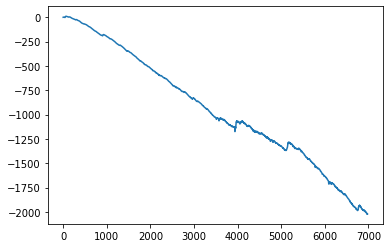

In [149]:
results['Delta'].plot()